## GMM-EM on MNIST Dataset

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.io
import scipy.stats
import timeit

### PCA

In [2]:
# PCA function
def pca(image_data, n_components = 2): # n_features, n_samples
    # mean and covariance matrix
    mu = np.mean(image_data, axis = 1).reshape(-1,1)
    xc = image_data - mu
    cov = xc.dot(xc.T) / len(image_data.T)

    # largest eigenvalues and corresponding eigenvectors
    k = n_components
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    lam, w = eigenvalues[-k:][::-1], eigenvectors[:, -k:][:,::-1]
    lam = lam.reshape((k, -1))
    pcs = w.T.dot(xc) / np.sqrt(lam)

    return lam, w, mu, pcs

In [3]:
def rev_pca(lams, vecs, mu_from, sigma_from, mu_data):
    sigma_to = [(vecs * lams.T).dot(sigma_k).dot(vecs.T * lams) for sigma_k in sigma_from]
    mu_to = [(vecs * np.sqrt(lams.T)).dot(mu_k) + mu_data.ravel() for mu_k in mu_from]
    return sigma_to, mu_to

### EM Algorithm

In [4]:
# GMM-EM model
def em(data, n_components = 2, max_iters = 200, random_seed = 1042):
    """
    data shape: (n_features, n_samples)
    """
    np.random.seed(random_seed)

    ## initialization
    n_features, n_samples = data.shape
    mu = [np.random.normal(size = (n_features)) for c in range(n_components)] # mu
    cov_mat = [np.random.normal(size = (n_features, n_features)) for c in range(n_components)] 
    sigma = [cov.dot(cov.T) + np.ones_like(cov) for cov in cov_mat] # sigma
    pi = [1./n_components for c in range(n_components)] # pi

    ## likelihood
    record_log_likelihood = []
    it = 0
    while it <= max_iters:
        ## posterior probability distributions
        probs = [p_ik * scipy.stats.multivariate_normal.pdf(data.T, mu_k, cov_k) for mu_k, cov_k, p_ik in zip(mu, sigma, pi)]
        sum_over_k = np.sum(np.array(probs), axis = 0)
        tau   = np.array(probs) / sum_over_k ## weight of each components for each data point
        log_likelihood = np.sum(np.log(sum_over_k))
   
        ## Update parameter sets       
        for k in range(n_components):
            pi[k] = np.mean(tau[k])
            mu[k] = data.dot(tau[k]) / np.sum(tau[k])
            diff = data - mu[k][:,None]
            sigma[k] = np.dot(tau[k] * diff, diff.T) / np.sum(tau[k])

        if it > 1 and log_likelihood - record_log_likelihood[-1] < 1e-4:
            break
        
        record_log_likelihood.append(log_likelihood)
        it += 1

    return tau, mu, sigma, pi, record_log_likelihood

### Plot Image Function

In [5]:
# plot image
def plot_image(images_mat, plot = "full", random_seed = 42): 
    """
    images imported from mat file (n_features, n_samples)
    plot: full/one
    """
    v, n = images_mat.shape
    h, w = int(np.sqrt(v)), int(np.sqrt(v))
    images = images_mat.reshape((h, w, n))

    cols = int(np.sqrt(n))
    rows = n // cols + 1
    total_image = np.zeros((rows*h, cols*w))
    count = 0

    for r in range(rows):
        for c in range(cols):
            if count == n:
                break
            total_image[r*h : (r+1)*h, c*w : (c+1)*w] = images[:,:, count]
            count += 1

    if plot == "full":
        plt.figure(figsize = (10, 10))
        plt.imshow(total_image.T, cmap='gray')
        plt.show()
    elif plot == "one":
        np.random.seed(random_seed)
        col1 = np.random.choice(cols//3, size = 1)
        col2 = np.random.choice(range(cols//2, cols), size = 1)
        row = np.random.choice(rows, 2)

        plt.figure(figsize = (4,2))
        plt.subplot(121)
        plt.imshow(total_image[row[0]*h : (row[0]+1)*h, col1[0]*w : (col1[0]+1)*w].T, cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(122)
        plt.imshow(total_image[row[1]*h : (row[1]+1)*h, col2[0]*w : (col2[0]+1)*w].T, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

### Read data

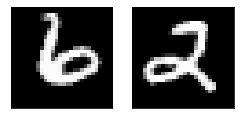

In [6]:
images = scipy.io.loadmat('data/data.mat')['data'] #784 * 1990
labels =  scipy.io.loadmat('data/label.mat')['trueLabel']
plot_image(images, plot = "one")

### Run EM

In [7]:
lams, vecs, mu_data, pcs = pca(images, n_components = 5)
tau, mu, sigma, pi, record_log_likelihood = em(pcs)
print("Weights of the Gaussian components: ", np.round(pi, 3))

Weights of the Gaussian components:  [0.493 0.507]


### Plot convergence

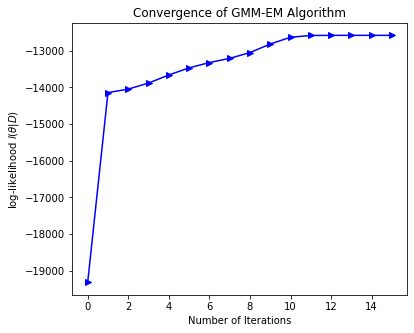

In [8]:
plt.figure(figsize = (6, 5))
plt.plot(record_log_likelihood, '->', color = 'b')
plt.ylabel("log-likelihood $l(\\theta|D)$")
plt.xlabel("Number of Iterations")
plt.title("Convergence of GMM-EM Algorithm")
plt.show()

### Reconstruct $\mu$ and $\Sigma$

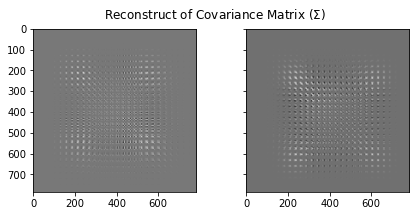

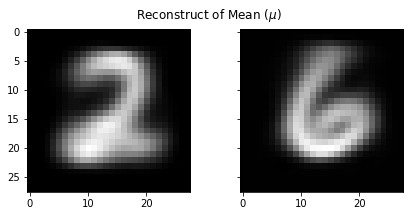

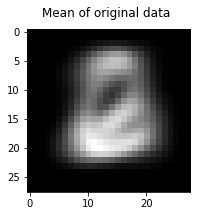

In [9]:
sigma_to, mu_to = rev_pca(lams, vecs, mu, sigma, mu_data)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3), sharex=True, sharey=True)
axs[0].imshow(sigma_to[0], cmap = 'gray')
axs[1].imshow(sigma_to[1], cmap = 'gray')
plt.suptitle("Reconstruct of Covariance Matrix ($\Sigma$)")

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 3), sharex=True, sharey=True)
axs[0].imshow(mu_to[0].reshape((28,28)).T, cmap = 'gray')
axs[1].imshow(mu_to[1].reshape((28,28)).T, cmap = 'gray')
plt.suptitle("Reconstruct of Mean ($\mu$)")

plt.figure(figsize = (3,3))
plt.imshow(mu_data.reshape((28,28)).T, cmap = 'gray')
plt.suptitle("Mean of original data")

plt.show()

### Labels

In [10]:
pred_labels = np.argmax(tau, axis = 0)
pred_labels[pred_labels == 0] = 2
pred_labels[pred_labels == 1] = 6
labels = labels.ravel()
total_miss = len(pred_labels) - np.sum(pred_labels == labels) 
miss_two =  1 - np.sum(pred_labels[labels == 2] == labels[labels == 2]) / len(labels[labels == 2])
miss_six =  1 - np.sum(pred_labels[labels == 6] == labels[labels == 6]) / len(labels[labels == 6])

print("Total mis-classifications: %d" % total_miss)
print("Digit 2 mis-classification rate: %.3f" % miss_two)
print("Digit 6 mis-classification rate: %.3f" % miss_six)

Total mis-classifications: 67
Digit 2 mis-classification rate: 0.058
Digit 6 mis-classification rate: 0.007


### Compare with K-means

In [14]:
from sklearn.cluster import KMeans

#km = KMeans(n_clusters = 2, random_state = 42).fit(images.T)
km = KMeans(n_clusters = 2, random_state = 42).fit(pcs.T)

kms_labels = km.labels_

kms_labels[kms_labels == 0] = 2
kms_labels[kms_labels == 1] = 6
total_miss = len(kms_labels) - np.sum(kms_labels == labels) 
miss_two =  1 - np.sum(kms_labels[labels == 2] == labels[labels == 2]) / len(labels[labels == 2])
miss_six =  1 - np.sum(kms_labels[labels == 6] == labels[labels == 6]) / len(labels[labels == 6])

print("Total mis-classifications: %d" % total_miss)
print("Digit 2 mis-classification rate: %.3f" % miss_two)
print("Digit 6 mis-classification rate: %.3f" % miss_six)

Total mis-classifications: 123
Digit 2 mis-classification rate: 0.109
Digit 6 mis-classification rate: 0.011
